In [ ]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt
from SpatioFreq import SpatioFreq

In [ ]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/root/anaconda3/envs/SpatioFreq/lib/R'
os.environ['R_USER'] = '/root/anaconda3/envs/SpatioFreq/lib/python3.8/site-packages/rpy2'

In [ ]:
adata = sc.read_h5ad('/data/spaTrack-main/data/ICC.ST.data/ICC.h5ad')
adata.var_names_make_unique()

In [ ]:
# define model
n_clusters = 8
model = SpatioFreq.SpatioFreq(adata, device=device,datatype = '10X',epochs=700,n_top_genes=6000,random_seed=7239)
# train model
adata = model.train()

Using random seed: 7239
Integrating frequency features...
Performing PCA to reduce dimensions...
6000
Features after PCA reduction: torch.Size([6415, 6000])
Begin to train ST data...


100%|██████████| 700/700 [04:19<00:00,  2.70it/s]


Optimization finished for ST data!


In [ ]:
from SpatioFreq.utils import clustering
radius = 20
tool = 'mclust' # mclust, leiden, and louvain

if tool == 'mclust':
   clustering(adata, n_clusters,radius=radius, method=tool) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [17]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['cluster'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['cluster'])
adata.uns['ARI'] = ARI

print('Dataset:')
print('ARI:', ARI)

/tmp/ipykernel_8815/963780831.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset:
ARI: 0.4330068404722225


In [ ]:
# adata.obsm["spatial"] = adata.obsm["spatial"] * (-1)

/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(-464.0, 7764.0, 19209.0, 3391.0)

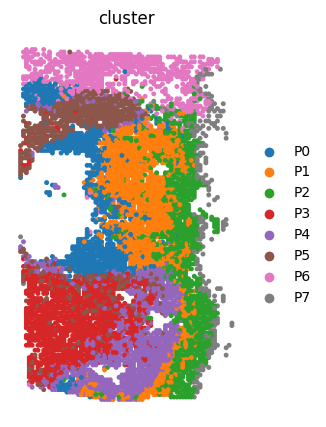

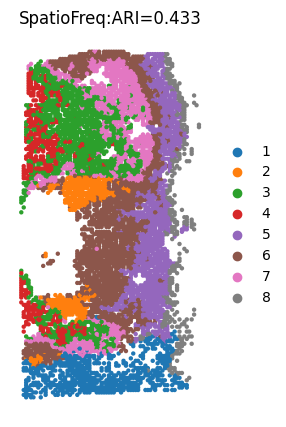

In [ ]:
plt.rcParams["figure.figsize"] = (3, 5)
sc.pl.embedding(adata, basis="spatial", color="cluster",s=50, show=False, title='cluster')
plt.axis('off')
fig, axes = plt.subplots(1, 1, figsize=(3, 5)) 
sc.pl.spatial(adata, color='domain', ax=axes, spot_size=180, show=False)  
axes.set_title('SpatioFreq:ARI=%.3f' % ARI)
plt.axis('off')

/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

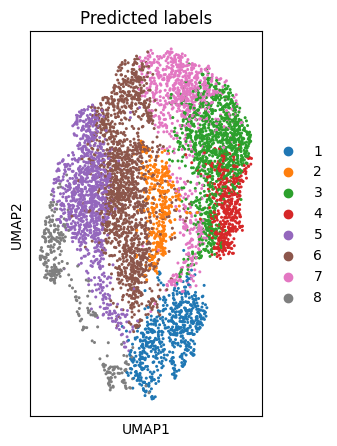

In [20]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

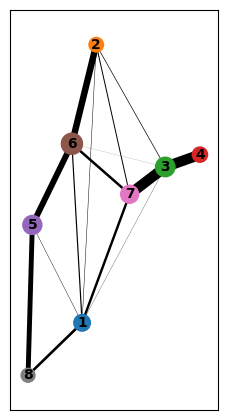

In [21]:
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.paga(adata, groups='domain')
sc.pl.paga(adata)

/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

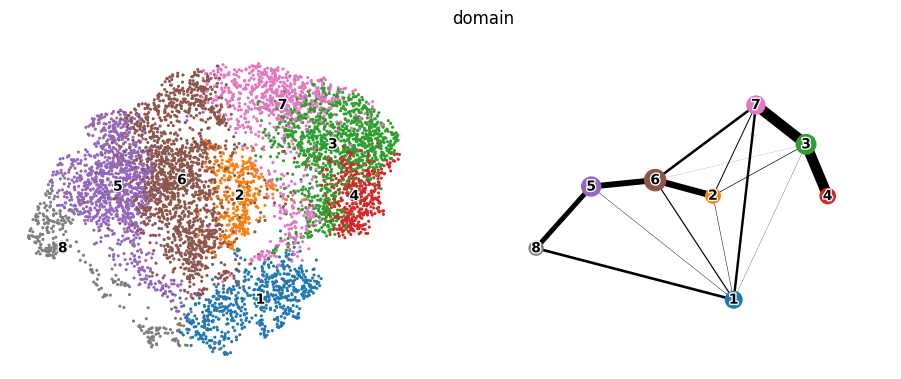

In [ ]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.paga_compare(adata,legend_fontsize=10, frameon=False, size=20,
    threshold=0.01,legend_fontoutline=2,
    # 这个值可能需要根据你的具体情况进行调整
    show=False,
)